In [290]:
# Configuration - Set crop type and model variant here
crop_type = "soybean"  # Change to "corn", "soybean", or "wheat" as needed
weatherformer_variant = "weatherformersinusoid"  # Change to "weatherformer" or "weatherformersinusoid" as needed
model_display_name = 'VITA'  # Both weatherformer variants show as WeatherFormer

# Extreme years for each crop (used for cross-validation)
EXTREME_YEARS = {
    "corn": [2002, 2004, 2009, 2012, 2014],
    "soybean": [2003, 2004, 2009, 2012, 2016],
    "wheat": [2002, 2003, 2005, 2009, 2011],
}

# Model configuration - define all model names and mappings here
MODEL_KEYS = ['weatherformer', 'bert', 'simmtm', 'gnnrnn', 'chronos']
MODEL_DISPLAY_NAMES = [model_display_name, 'T-BERT', 'SimMTM', 'GNN-RNN', 'Chronos']

# Colors and markers for models - performance order: VITA, BERT, SimMTM, GNN-RNN, Chronos
MODEL_COLORS = {
    model_display_name: '#F24236', 
    'T-BERT': '#2E86AB', 
    'SimMTM': '#28A745', 
    'GNN-RNN': '#2D3748', 
    'Chronos': '#8B5CF6'
}
MODEL_MARKERS = {
    model_display_name: 's', 
    'T-BERT': 'o', 
    'SimMTM': 'D', 
    'GNN-RNN': '^', 
    'Chronos': 'p'
}

# Create mapping from model keys to display names
MODEL_KEY_TO_DISPLAY = dict(zip(MODEL_KEYS, MODEL_DISPLAY_NAMES))

import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

# Comprehensive rcParams for publication-ready neurips paper - SET ONCE
plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 24,
    'axes.titlesize': 26,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 12,
    'lines.markeredgewidth': 2.5,
    'legend.frameon': False,
    'figure.dpi': 300,
    'font.weight': 'normal',
    'axes.labelweight': 'bold',
    'axes.titleweight': 'bold',
    'grid.alpha': 0.3,
    'grid.linewidth': 1,
    'figure.figsize': (20, 6),
    'axes.grid': True,
})

print(f"Crop type set to: {crop_type}")
print(f"WeatherFormer variant set to: {weatherformer_variant}")


Crop type set to: soybean
WeatherFormer variant set to: weatherformersinusoid


In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data using the crop_type and weatherformer_variant parameters
bert_data = pd.read_csv(f'data/grid_search_bert_pretrained_{crop_type}.tsv', sep='\t')
weatherformer_data = pd.read_csv(f'data/grid_search_{weatherformer_variant}_pretrained_{crop_type}.tsv', sep='\t')
simmtm_data = pd.read_csv(f'data/grid_search_simmtm_pretrained_{crop_type}.tsv', sep='\t')
gnnrnn_data = pd.read_csv(f'data/grid_search_gnnrnn_pretrained_{crop_type}.tsv', sep='\t')
chronos_data = pd.read_csv(f'data/grid_search_chronos_pretrained_{crop_type}.tsv', sep='\t')

# Extract R² values (removing ± error part)
bert_data['r2'] = bert_data['year_15_r2'].str.split(' ± ').str[0].astype(float)
weatherformer_data['r2'] = weatherformer_data['year_15_r2'].str.split(' ± ').str[0].astype(float)
simmtm_data['r2'] = simmtm_data['year_15_r2'].str.split(' ± ').str[0].astype(float)
gnnrnn_data['r2'] = gnnrnn_data['year_15_r2'].str.split(' ± ').str[0].astype(float)
chronos_data['r2'] = chronos_data['year_15_r2'].str.split(' ± ').str[0].astype(float)

print("Data loaded successfully!")
print(f"BERT data shape: {bert_data.shape}")
print(f"WeatherFormer data shape: {weatherformer_data.shape}")
print(f"SimMTM data shape: {simmtm_data.shape}")
print(f"GNN-RNN data shape: {gnnrnn_data.shape}")
print(f"Chronos data shape: {chronos_data.shape}")

# Display first few rows
print("\nBERT data preview:")
print(bert_data[['batch_size', 'init_lr', 'beta', 'r2']].head())
print("\nWeatherFormer data preview:")
print(weatherformer_data[['batch_size', 'init_lr', 'beta', 'r2']].head())
print("\nSimMTM data preview:")
print(simmtm_data[['batch_size', 'init_lr', 'beta', 'r2']].head())
print("\nGNN-RNN data preview:")
print(gnnrnn_data[['batch_size', 'init_lr', 'beta', 'r2']].head())
print("\nChronos data preview:")
print(chronos_data[['batch_size', 'init_lr', 'beta', 'r2']].head())


Data loaded successfully!
BERT data shape: (9, 8)
WeatherFormer data shape: (27, 8)
SimMTM data shape: (9, 8)
GNN-RNN data shape: (9, 8)
Chronos data shape: (9, 8)

BERT data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.705
1          16  0.00050   0.0  0.701
2          16  0.00100   0.0  0.692
3          32  0.00025   0.0  0.691
4          32  0.00050   0.0  0.697

WeatherFormer data preview:
   batch_size  init_lr    beta     r2
0          16  0.00025  0.0000  0.718
1          16  0.00025  0.0001  0.727
2          16  0.00025  0.0010  0.678
3          16  0.00050  0.0000  0.723
4          16  0.00050  0.0001  0.711

SimMTM data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.668
1          16  0.00050   0.0  0.685
2          16  0.00100   0.0  0.684
3          32  0.00025   0.0  0.673
4          32  0.00050   0.0  0.669

GNN-RNN data preview:
   batch_size  init_lr  beta     r2
0          16  0.00025   0.0  0.632
1         

In [292]:
# Prepare data for each subplot
models = {
    'bert': bert_data,
    'weatherformer': weatherformer_data,
    'simmtm': simmtm_data,
    'gnnrnn': gnnrnn_data,
    'chronos': chronos_data
}

batch_sizes = [16, 32, 64]
learning_rates = [0.00025, 0.0005, 0.001]
betas = [0.0, 0.0001, 0.001]

# 1. Batch size vs R²
batch_results = {}
for model_name, data in models.items():
    batch_results[model_name] = []
    for bs in batch_sizes:
        best_r2 = data[data['batch_size'] == bs]['r2'].max()
        batch_results[model_name].append(best_r2)

# 2. Learning rate vs R²
lr_results = {}
for model_name, data in models.items():
    lr_results[model_name] = []
    for lr in learning_rates:
        best_r2 = data[data['init_lr'] == lr]['r2'].max()
        lr_results[model_name].append(best_r2)

# 3. Beta vs R² (WeatherFormer only)
beta_weatherformer_r2 = []
for beta in betas:
    wf_best = weatherformer_data[weatherformer_data['beta'] == beta]['r2'].max()
    beta_weatherformer_r2.append(wf_best)

print("Data prepared for plotting:")
print(f"Batch sizes: {batch_sizes}")
for model_name, results in batch_results.items():
    print(f"{model_name.upper()} R² by batch size: {results}")
print(f"Learning rates: {learning_rates}")
for model_name, results in lr_results.items():
    print(f"{model_name.upper()} R² by learning rate: {results}")
print(f"Betas: {betas}")
print(f"WeatherFormer R² by beta: {beta_weatherformer_r2}")


Data prepared for plotting:
Batch sizes: [16, 32, 64]
BERT R² by batch size: [0.705, 0.697, 0.701]
WEATHERFORMER R² by batch size: [0.727, 0.722, 0.714]
SIMMTM R² by batch size: [0.685, 0.673, 0.678]
GNNRNN R² by batch size: [0.643, 0.642, 0.647]
CHRONOS R² by batch size: [0.601, 0.615, 0.622]
Learning rates: [0.00025, 0.0005, 0.001]
BERT R² by learning rate: [0.705, 0.701, 0.698]
WEATHERFORMER R² by learning rate: [0.727, 0.723, 0.721]
SIMMTM R² by learning rate: [0.678, 0.685, 0.684]
GNNRNN R² by learning rate: [0.632, 0.643, 0.647]
CHRONOS R² by learning rate: [0.622, 0.606, 0.589]
Betas: [0.0, 0.0001, 0.001]
WeatherFormer R² by beta: [0.723, 0.727, 0.698]


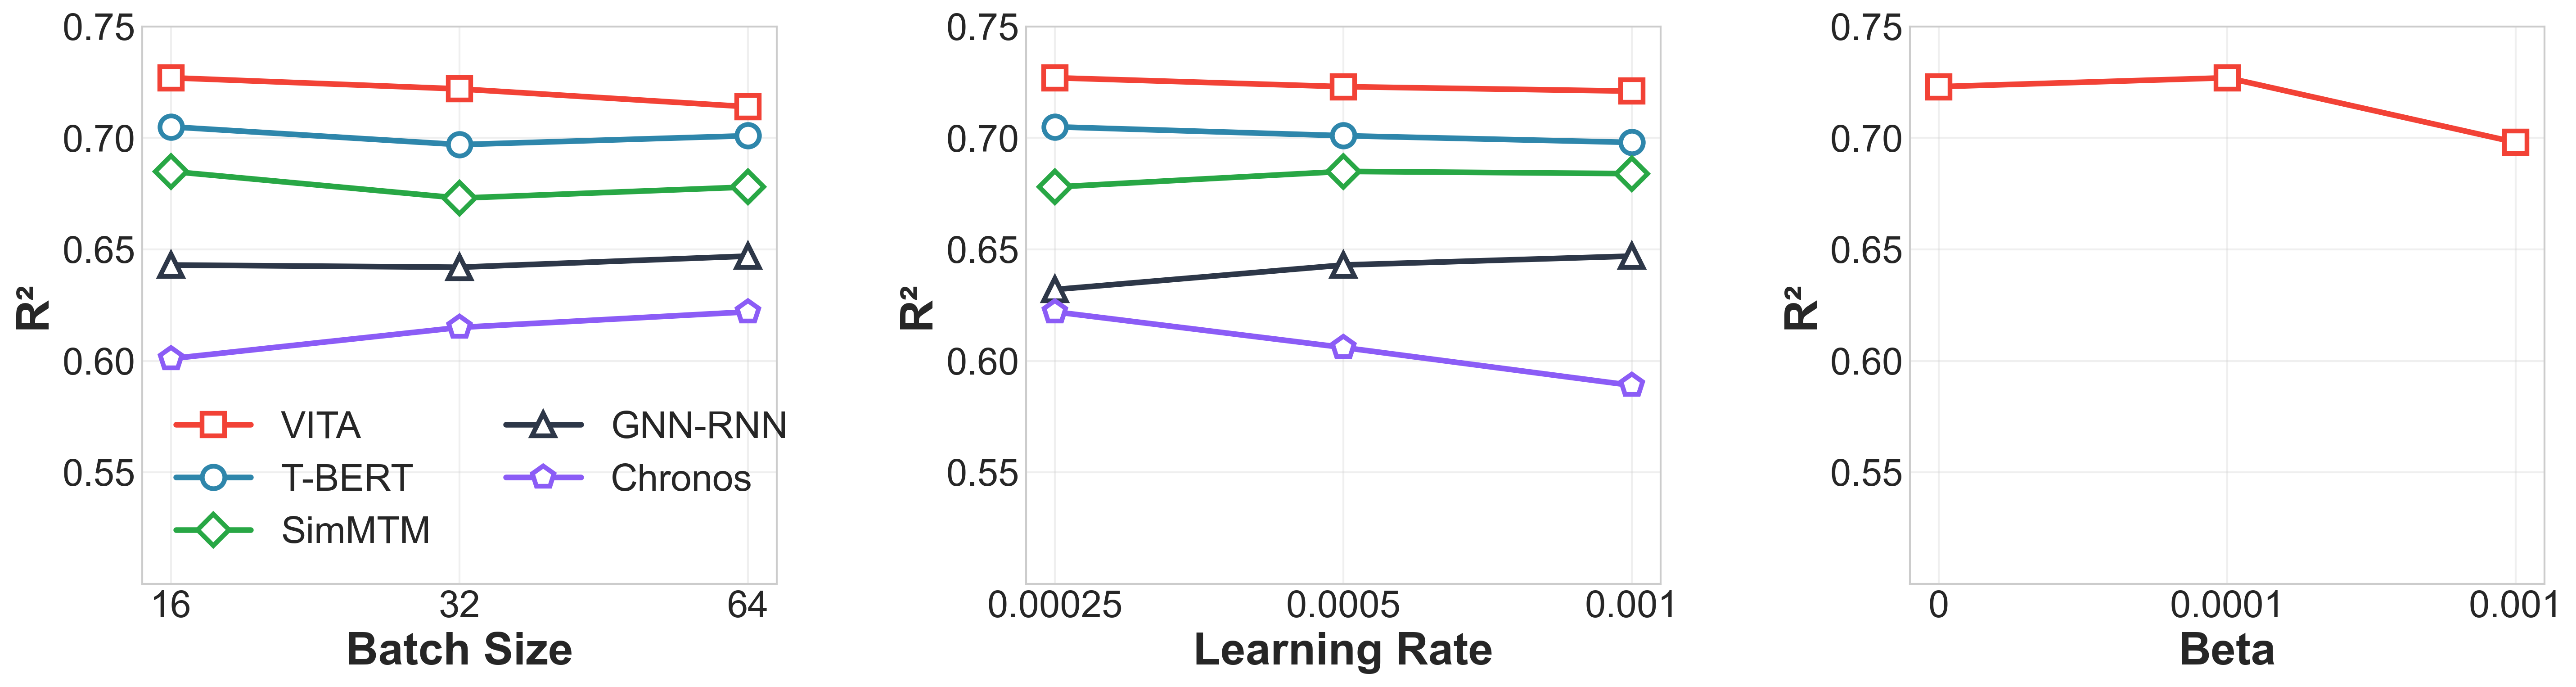

saved as '../data/latex/img/grid_search_soybean.pdf'


In [293]:
# Create the professional neurips-style plot - all styling handled by rcParams
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

# Plot 1: Batch Size vs R² (legend only here) - performance order
x_batch = np.arange(len(batch_sizes))
for model_key in MODEL_KEYS:
    display_name = MODEL_KEY_TO_DISPLAY[model_key]
    ax1.plot(x_batch, batch_results[model_key], color=MODEL_COLORS[display_name], marker=MODEL_MARKERS[display_name], 
             label=display_name, markerfacecolor='white', markeredgecolor=MODEL_COLORS[display_name])

ax1.set_xlabel('Batch Size')
ax1.set_ylabel('R²')
ax1.set_xticks(x_batch)
ax1.set_xticklabels(batch_sizes)
ax1.legend(loc='lower left', ncol=2)

# Plot 2: Learning Rate vs R² (no legend) - same order
x_lr = np.arange(len(learning_rates))
for model_key in MODEL_KEYS:
    display_name = MODEL_KEY_TO_DISPLAY[model_key]
    ax2.plot(x_lr, lr_results[model_key], color=MODEL_COLORS[display_name], marker=MODEL_MARKERS[display_name], 
             markerfacecolor='white', markeredgecolor=MODEL_COLORS[display_name])

ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('R²')
ax2.set_xticks(x_lr)
ax2.set_xticklabels(['0.00025', '0.0005', '0.001'])

# Plot 3: Beta vs R² (WeatherFormer only, no legend)
x_beta = np.arange(len(betas))
ax3.plot(x_beta, beta_weatherformer_r2, color=MODEL_COLORS[model_display_name], marker=MODEL_MARKERS[model_display_name], 
         markerfacecolor='white', markeredgecolor=MODEL_COLORS[model_display_name])

ax3.set_xlabel('Beta')
ax3.set_ylabel('R²')
ax3.set_xticks(x_beta)
ax3.set_xticklabels(['0', '0.0001', '0.001'])


if crop_type == 'soybean':
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0.50, 0.75)
        ax.set_yticks([0.55, 0.60, 0.65, 0.70, 0.75])
elif crop_type == 'wheat':
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0.23, 0.65)
        ax.set_yticks([0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60])
else:  # corn
    for ax in [ax1, ax2, ax3]:
        ax.set_ylim(0.35, 0.75)
        ax.set_yticks([0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75])

# Create output directory if it doesn't exist
import os
os.makedirs('../data/latex/img', exist_ok=True)

# Adjust layout and save
plt.tight_layout(pad=2.0)
plt.savefig(f'../data/latex/img/grid_search_{crop_type}.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"saved as '../data/latex/img/grid_search_{crop_type}.pdf'")


In [294]:
import json

# Load JSON files for individual R² values
with open(f'data/grid_search_bert_pretrained_{crop_type}.json', 'r') as f:
    bert_json = json.load(f)

with open(f'data/grid_search_{weatherformer_variant}_pretrained_{crop_type}.json', 'r') as f:
    weatherformer_json = json.load(f)

with open(f'data/grid_search_simmtm_pretrained_{crop_type}.json', 'r') as f:
    simmtm_json = json.load(f)

with open(f'data/grid_search_gnnrnn_pretrained_{crop_type}.json', 'r') as f:
    gnnrnn_json = json.load(f)

with open(f'data/grid_search_chronos_pretrained_{crop_type}.json', 'r') as f:
    chronos_json = json.load(f)

# Find the best performing model for each type based on mean R²
best_configs = {}
best_r2s = {}
json_data = {
    'bert': bert_json,
    'weatherformer': weatherformer_json,
    'simmtm': simmtm_json,
    'gnnrnn': gnnrnn_json,
    'chronos': chronos_json
}

# Find best configuration for each model
for model_name, data in json_data.items():
    best_config = None
    best_r2 = -1
    for config_name, results in data.items():
        mean_r2 = results['year_15']['mean_r2']
        if mean_r2 > best_r2:
            best_r2 = mean_r2
            best_config = config_name
    best_configs[model_name] = best_config
    best_r2s[model_name] = best_r2

# Print results
for model_name in ['bert', 'weatherformer', 'simmtm', 'gnnrnn', 'chronos']:
    display_name = model_display_name if model_name == 'weatherformer' else model_name.upper()
    print(f"Best {display_name} configuration: {best_configs[model_name]}")
    print(f"Best {display_name} mean R²: {best_r2s[model_name]:.3f}")

# Extract individual R² values for the best configurations
best_individual_r2 = {}
for model_name in ['bert', 'weatherformer', 'simmtm', 'gnnrnn', 'chronos']:
    best_individual_r2[model_name] = json_data[model_name][best_configs[model_name]]['year_15']['individual_r2_values']

print(f"\nBest individual R² values:")
for model_name in ['bert', 'weatherformer', 'simmtm', 'gnnrnn', 'chronos']:
    display_name = model_display_name if model_name == 'weatherformer' else model_name.upper()
    print(f"Best {display_name} individual R² values: {best_individual_r2[model_name]}")


Best BERT configuration: bert_pretrained_soybean_beta_0.0_bs_16_lr_0.00025
Best BERT mean R²: 0.705
Best VITA configuration: weatherformersinusoid_pretrained_soybean_beta_0.0001_bs_16_lr_0.00025
Best VITA mean R²: 0.727
Best SIMMTM configuration: simmtm_pretrained_soybean_beta_0.0_bs_16_lr_0.0005
Best SIMMTM mean R²: 0.685
Best GNNRNN configuration: gnnrnn_pretrained_soybean_beta_0.0_bs_64_lr_0.001
Best GNNRNN mean R²: 0.647
Best CHRONOS configuration: chronos_pretrained_soybean_beta_0.0_bs_64_lr_0.00025
Best CHRONOS mean R²: 0.622

Best individual R² values:
Best BERT individual R² values: [0.5100715366716411, 0.6617667723559935, 0.775661974911123, 0.7285652996276953, 0.8478268398239197]
Best VITA individual R² values: [0.5871269504573595, 0.7112002347619198, 0.8089631747238377, 0.6937977391126908, 0.8360521193017281]
Best SIMMTM individual R² values: [0.4673969374578686, 0.6591294890347186, 0.7722335098577741, 0.690424246435297, 0.8365488626205607]
Best GNNRNN individual R² values: [

In [295]:
# Increase legend, ticks, and axis labels by 50% for individual plot
plt.rcParams.update({
    'axes.labelsize': 36,      # 24 * 1.5
    'xtick.labelsize': 30,     # 20 * 1.5  
    'ytick.labelsize': 30,     # 20 * 1.5
    'legend.fontsize': 30,     # 20 * 1.5
})


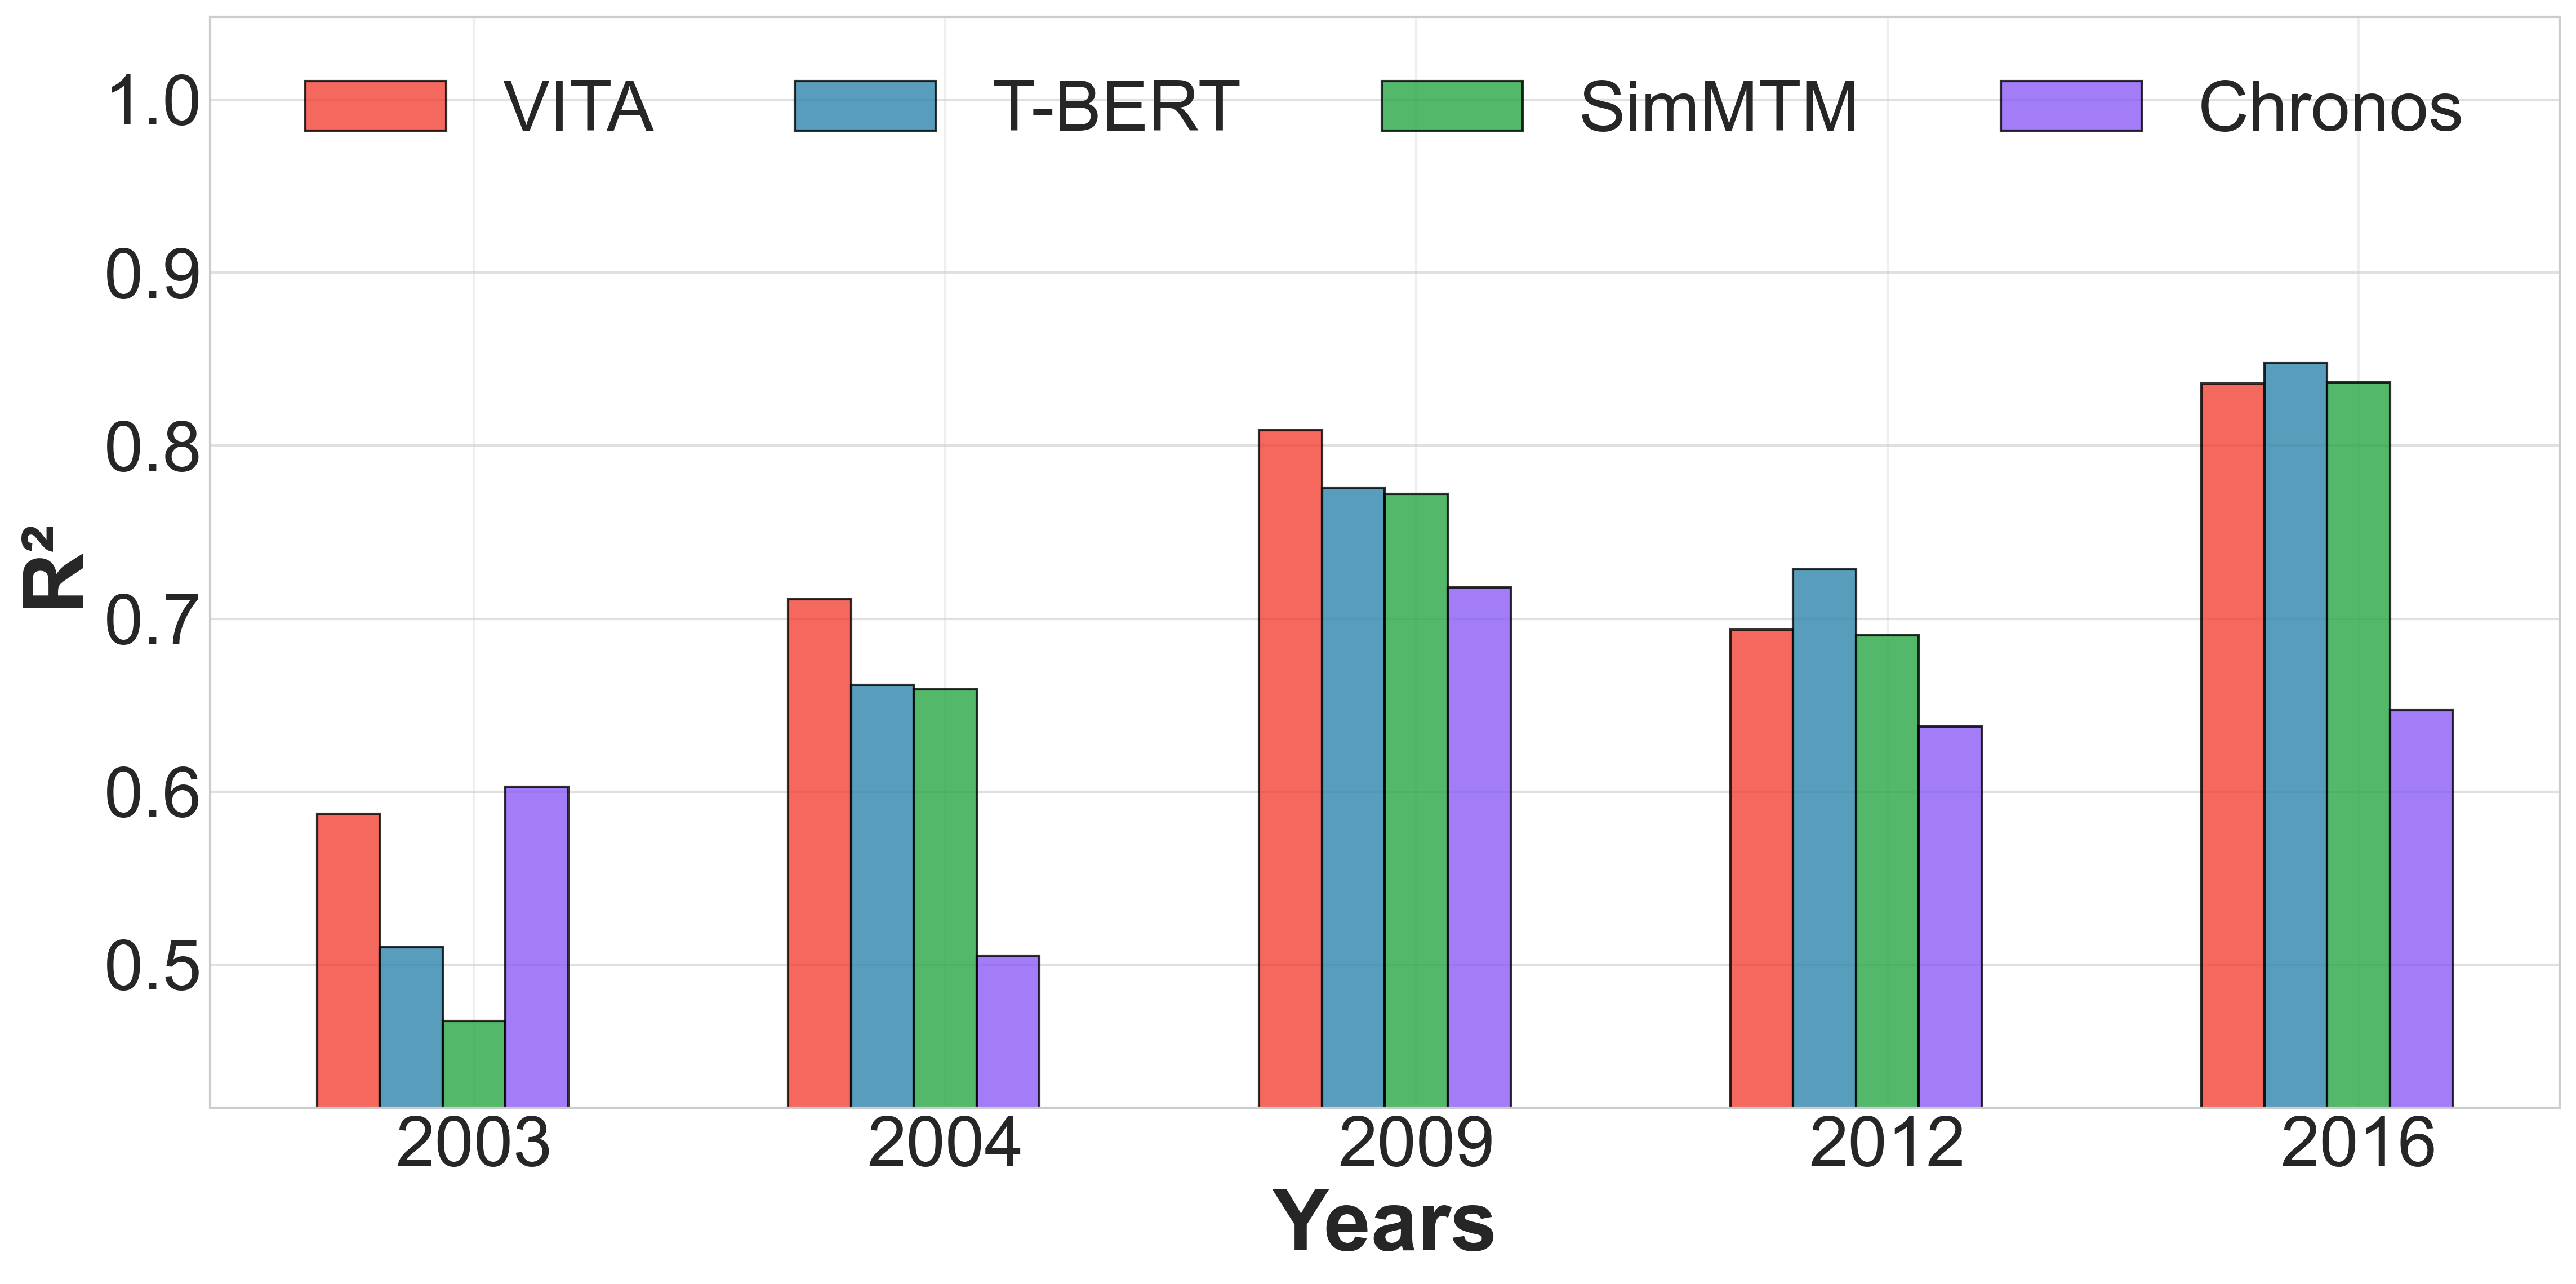

Bar plot saved as '../data/latex/img/individual_r2_comparison_soybean.pdf'


In [296]:
# Create bar plot for individual R² values - neurips style
fig, ax = plt.subplots(figsize=(16, 8))

# Number of folds
n_folds = len(best_individual_r2['bert'])
fold_labels = [str(year) for year in EXTREME_YEARS[crop_type]]

# Set up bar positions for 5 models - make groups closer together
x = np.arange(n_folds) * 0.6  # Multiply by 0.6 to bring year groups closer
width = 0.08  # Smaller width to fit 5 models

# Create bars using for loop (excluding GNN-RNN)
bar_model_keys = [key for key in MODEL_KEYS if key != 'gnnrnn']
bars = []
for i, model_key in enumerate(bar_model_keys):
    display_name = MODEL_KEY_TO_DISPLAY[model_key]
    offset = (i - 2) * width  # Center the bars around x
    bar = ax.bar(x + offset, best_individual_r2[model_key], width, 
                 label=display_name, color=MODEL_COLORS[display_name], alpha=0.8, edgecolor='black')
    bars.append(bar)

# Customize the plot - no title for neurips style
ax.set_xlabel('Years')
ax.set_ylabel('R²')
ax.set_xticks(x)
ax.set_xticklabels(fold_labels)
ax.legend(loc='upper center', ncol=4, frameon=False)

del best_individual_r2["gnnrnn"]

# Set y-axis limits to better show the data
all_r2_values = [val for model_r2 in best_individual_r2.values() for val in model_r2]
ax.set_ylim(min(all_r2_values) - 0.05, max(all_r2_values) + 0.20)

# Add grid for better readability
ax.grid(True, alpha=0.6, axis='y')

plt.tight_layout()
plt.savefig(f'../data/latex/img/individual_r2_comparison_{crop_type}.pdf', dpi=300, bbox_inches='tight')
plt.show()

print(f"Bar plot saved as '../data/latex/img/individual_r2_comparison_{crop_type}.pdf'")


In [297]:
# Compute mean and standard deviation of running time in minutes from JSON files
import numpy as np

def extract_runtime_minutes(json_data, batch_size=32):
    """Extract runtime minutes from JSON data, filtered by batch size for fairness"""
    runtimes = []
    for config_name, results in json_data.items():
        # Filter for specific batch size only for fair comparison
        if f'_bs_{batch_size}_' in config_name:
            if 'year_15' in results and 'runtime_seconds' in results['year_15']:
                runtime_minutes = results['year_15']['runtime_seconds'] / 60.0
                runtimes.append(runtime_minutes)
    return runtimes

def print_runtime_stats(runtimes, model_name, prefix="\n"):
    """Print runtime statistics for a given model"""
    if runtimes:
        mean = np.mean(runtimes)
        std = np.std(runtimes, ddof=1)  # sample standard deviation
        print(f"{prefix}{model_name}:")
        print(f"  Mean: {mean:.2f} minutes")
        print(f"  Std:  {std:.2f} minutes")
    else:
        print(f"{prefix}{model_name}: No runtime data found")

# Extract runtime data for each model
runtime_data = {}
for model_key in MODEL_KEYS:
    if model_key == 'weatherformer':
        runtime_data[model_key] = extract_runtime_minutes(weatherformer_json)
    elif model_key == 'bert':
        runtime_data[model_key] = extract_runtime_minutes(bert_json)
    elif model_key == 'simmtm':
        runtime_data[model_key] = extract_runtime_minutes(simmtm_json)
    elif model_key == 'gnnrnn':
        runtime_data[model_key] = extract_runtime_minutes(gnnrnn_json)
    elif model_key == 'chronos':
        runtime_data[model_key] = extract_runtime_minutes(chronos_json)

# Compute statistics
print("Running Time Statistics (in minutes):")
print("=" * 50)

for model_key in MODEL_KEYS:
    display_name = MODEL_KEY_TO_DISPLAY[model_key]
    print_runtime_stats(runtime_data[model_key], display_name, prefix="")

# Overall statistics across all models
all_runtimes = []
for runtimes in runtime_data.values():
    all_runtimes.extend(runtimes)

if all_runtimes:
    overall_mean = np.mean(all_runtimes)
    overall_std = np.std(all_runtimes, ddof=1)
    print(f"\nOverall (all models, batch size 32):")
    print(f"  Mean: {overall_mean:.2f} minutes")
    print(f"  Std:  {overall_std:.2f} minutes")
    print(f"  Total experiments: {len(all_runtimes)}")


Running Time Statistics (in minutes):
VITA:
  Mean: 25.53 minutes
  Std:  0.58 minutes
T-BERT:
  Mean: 24.69 minutes
  Std:  0.13 minutes
SimMTM:
  Mean: 25.92 minutes
  Std:  0.01 minutes
GNN-RNN:
  Mean: 7.92 minutes
  Std:  0.25 minutes
Chronos:
  Mean: 43.05 minutes
  Std:  0.31 minutes

Overall (all models, batch size 32):
  Mean: 25.45 minutes
  Std:  9.64 minutes
  Total experiments: 21


In [298]:
import pandas as pd
from scipy.stats import ttest_ind

def evaluate_pretraining_effect(model_name, crop_type):
    """
    Evaluate the effect of pretraining on a given model.
    
    Args:
        model_name (str): Name of the model ('bert', 'weatherformersinusoid', 'simmtm', 'gnnrnn')
    
    Returns:
        dict: Statistics comparing pretrained vs not-pretrained performance
    """
    # Construct file paths based on model name and crop_type
    not_pretrained_path = f'data/grid_search_{model_name}_not_pretrained_{crop_type}.tsv'
    pretrained_path = f'data/grid_search_{model_name}_pretrained_{crop_type}.tsv'
    
    try:
        # Load data
        df_not_pretrained = pd.read_csv(not_pretrained_path, sep='\t')
        df_pretrained = pd.read_csv(pretrained_path, sep='\t')
        
        # Extract R^2 values using the same pattern as existing code
        r2_not_pretrained = df_not_pretrained['year_15_r2'].str.split(' ± ').str[0].astype(float)
        r2_pretrained = df_pretrained['year_15_r2'].str.split(' ± ').str[0].astype(float)
        
        # Compute statistics
        stats = {
            'model_name': model_name,
            'crop_type': crop_type,
            'not_pretrained': {
                'mean_r2': r2_not_pretrained.mean(),
                'std_r2': r2_not_pretrained.std(),
                'best_r2': r2_not_pretrained.max(),
                'n_experiments': len(r2_not_pretrained)
            },
            'pretrained': {
                'mean_r2': r2_pretrained.mean(),
                'std_r2': r2_pretrained.std(),
                'best_r2': r2_pretrained.max(),
                'n_experiments': len(r2_pretrained)
            }
        }
        
        # Perform t-test
        t_stat, p_val = ttest_ind(r2_pretrained, r2_not_pretrained, equal_var=False)
        stats['t_stat'] = t_stat
        stats['p_val'] = p_val
        
        # Calculate improvement
        stats['improvement'] = {
            'mean_diff': stats['pretrained']['mean_r2'] - stats['not_pretrained']['mean_r2'],
            'percent_improvement': ((stats['pretrained']['mean_r2'] - stats['not_pretrained']['mean_r2']) / stats['not_pretrained']['mean_r2']) * 100,
            'best_diff': stats['pretrained']['best_r2'] - stats['not_pretrained']['best_r2']
        }
        
        return stats
        
    except FileNotFoundError as e:
        print(f"Error: Could not find data files for model '{model_name}'")
        print(f"Expected files:")
        print(f"  - {not_pretrained_path}")
        print(f"  - {pretrained_path}")
        return None
    except Exception as e:
        print(f"Error processing data for model '{model_name}': {str(e)}")
        return None

# Example usage - test with one of the known models
for crop_type in ['soybean', 'corn', 'wheat']:
    print(f"Testing pretraining effect evaluation for {crop_type}...")
    print("=" * 50)
    test_result = evaluate_pretraining_effect(weatherformer_variant, crop_type)
    if test_result:
        print(f"Model: {test_result['model_name']}")
        print(f"Crop: {test_result['crop_type']}")
        print(f"Not pretrained - Mean R²: {test_result['not_pretrained']['mean_r2']:.3f} ± {test_result['not_pretrained']['std_r2']:.3f}")
        print(f"Not pretrained - Best R²: {test_result['not_pretrained']['best_r2']:.3f}")
        print(f"Pretrained - Mean R²: {test_result['pretrained']['mean_r2']:.3f} ± {test_result['pretrained']['std_r2']:.3f}")
        print(f"Pretrained - Best R²: {test_result['pretrained']['best_r2']:.3f}")
        print(f"Mean Improvement: {test_result['improvement']['mean_diff']:.3f} ({test_result['improvement']['percent_improvement']:.1f}%)")
        print(f"Best Improvement: {test_result['improvement']['best_diff']:.3f}")
        print(f"T-test: t={test_result['t_stat']:.2f}, p={test_result['p_val']}")
        if test_result['p_val'] < 0.05:
            print("Statistical significance: p < 0.05 (significant)")
        else:
            print("Statistical significance: p ≥ 0.05 (not significant)")


Testing pretraining effect evaluation for soybean...
Model: weatherformersinusoid
Crop: soybean
Not pretrained - Mean R²: 0.569 ± 0.139
Not pretrained - Best R²: 0.684
Pretrained - Mean R²: 0.698 ± 0.019
Pretrained - Best R²: 0.727
Mean Improvement: 0.129 (22.7%)
Best Improvement: 0.043
T-test: t=4.80, p=5.2518551332464655e-05
Statistical significance: p < 0.05 (significant)
Testing pretraining effect evaluation for corn...
Model: weatherformersinusoid
Crop: corn
Not pretrained - Mean R²: 0.469 ± 0.227
Not pretrained - Best R²: 0.672
Pretrained - Mean R²: 0.703 ± 0.015
Pretrained - Best R²: 0.729
Mean Improvement: 0.234 (49.8%)
Best Improvement: 0.057
T-test: t=5.35, p=1.3146628923691798e-05
Statistical significance: p < 0.05 (significant)
Testing pretraining effect evaluation for wheat...
Model: weatherformersinusoid
Crop: wheat
Not pretrained - Mean R²: 0.447 ± 0.058
Not pretrained - Best R²: 0.545
Pretrained - Mean R²: 0.483 ± 0.038
Pretrained - Best R²: 0.599
Mean Improvement: 0.03